In [1]:
# Shiman Ding, shiman@berkeley.edu
# IEOR, 24104985
# 09/10/2016, AY250-HW2
# Data Visualization

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

0) Critique the most important figure from a seminal paper in your field. Provide the original figure/caption. In your own words, what story is this figure trying to convey? What does it do well? What could have been done better? What elements didn't need to be present to still convey the same story?

<img src="hw_2_data/critic.png">
<br/>

The figure is trying to show how min cuts can be achieved via clustering. The example is simple enough with insights. But G1 and G2 are not clearly defined in the graph. They may also use dashed line for cuts and clusters. They may also use different color for cuts and clusters. If flow is included in the graph, that would be better.

2) Reproduce in matplotlib the provided plot stocks.png  Use the provided datafiles ny_temps.txt, yahoo_data.txt, and google_data.txt. Provide your new plot and the Python code.

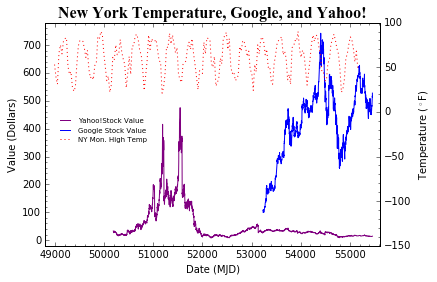

In [3]:
ny_temps = np.loadtxt("hw_2_data/ny_temps.txt", skiprows=1)
yahoo_data = np.loadtxt("hw_2_data/yahoo_data.txt", skiprows=1)
google_data = np.loadtxt("hw_2_data/google_data.txt", skiprows=1)
fig = plt.figure()
ax1 = fig.add_subplot(111)

yahoo = ax1.plot(yahoo_data[:,0], yahoo_data[:,1], color = 'purple', 
         linestyle = '-', label = "Yahoo!Stock Value")
google = ax1.plot(google_data[:,0], google_data[:,1], color = 'blue', 
         linestyle = '-', label = "Google Stock Value")

# add secondary y axis
ax2 = ax1.twinx()
temps = ax2.plot(ny_temps[:,0], ny_temps[:,1], color = 'red', 
         linestyle = ':', label = "NY Mon. High Temp")

# add legend together
data = yahoo + google + temps
labs = [l.get_label() for l in data]
ax1.legend(data, labs, loc=(0.03,.45), prop={'size':7}, frameon=False)

ax1.set_title("New York Temperature, Google, and Yahoo!", 
              size = 16, family='Times New Roman', fontweight="bold")
ax1.set_xlabel("Date (MJD)")
ax1.set_ylabel("Value (Dollars)")
ax2.set_ylabel("Temperature ($^\circ$F)")
ax1.set_xlim(48800, 55620)
ax1.set_ylim(-20, 780)
ax1.minorticks_on()
ax2.set_ylim(-150,100)
ax2.minorticks_on()

3) Make a generic "Brushing" graph

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle

import numpy as np
import plotly
import pandas as pd
import datashader
import seaborn as sns
import sys
import os

from bokeh.io import output_file, show
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure

%matplotlib notebook

In [2]:
flowers = pd.read_table("hw_2_data/flowers.csv", sep=",").set_index("species")

In [314]:
class DrawClass:

    def __init__(self, data, colors):
        """ Initialize the brusher plots
        
        data: pd.DataFrame - figure will have NxN subplots where N
                                is the number of features/columns 
        colors: np.ndarray - the colors group each row into categories 
                                accordingly
        """
        self.data = data
        self.colors = colors
        self.size = data.shape[1]
        self.fig, self.axes = plt.subplots(self.size, self.size)
        self.ax_data = {}
        self.ax_dict = {}
        self.active = np.array(data.shape[0])
        
        self.rect = None
        self.current_axes = None
        self.xy0 = None
        self.xy1 = None
        
        
        for x_ix, x_data in enumerate(self.data.columns):
            for y_ix, y_data in enumerate(self.data.columns):
                ax_temp = self.axes[y_ix, x_ix]
                scatterplot = ax_temp.scatter(data[x_data], data[y_data], alpha = 0.4)
                
                ax_temp.set_xlim(self.data[x_data].min(), self.data[x_data].max())
                ax_temp.set_ylim(self.data[y_data].min(), self.data[y_data].max())
                
                ax_temp.xaxis.set_ticks([])
                ax_temp.yaxis.set_ticks([])
                
                scatterplot.set_color(colors)
                
                self.ax_data[x_ix, y_ix] = scatterplot
                self.ax_dict[str(ax_temp)] = (x_data, y_data)
                
        
        self.cids = {}
        self.cids['button_press_event'] = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        self.cids['button_release_event'] = self.fig.canvas.mpl_connect('button_release_event', self.offclick)
        
        
        self.fig.show()
        self.flush()
            
    def flush(self):
        """
        Desciption:
        Flush std out and draw canvas - to make sure everything is written right now
        """
        sys.stdout.flush()
        self.fig.canvas.draw()
        
        
    def onclick(self, event):
        if event.x is None or event.y is None:
            return
        
        #self.active = np.ones(self.data.shape[0])
        #self.update_colors(active = self.active.values)
        
        self.ax0 = event.inaxes
        self.xy0 = (event.xdata, event.ydata)
        self.flush()
        
    def offclick(self, event):
        if event.xdata is None or event.ydata is None: return
        if event.inaxes != self.ax0: return
                
        self.xy1 = (event.xdata, event.ydata)
        
        # Make a rectangular, finding upper left point, width, height
        xmin = min(self.xy0[0], self.xy1[0])
        xmax = max(self.xy0[0], self.xy1[0])
        ymin = min(self.xy0[1], self.xy1[1])
        ymax = max(self.xy0[1], self.xy1[1])
        
        width = xmax - xmin
        height = ymax - ymin
        area = width * height
        
        self.rect = Rectangle((xmin, ymin), width, height, color = 'k', alpha = 0.0)
        self.ax0.add_patch(self.rect)
        self.update_state(xmin, xmax, ymin, ymax)
        self.flush()


    def update_state(self, xmin, xmax, ymin, ymax):
        # find out column names
        x_label, y_label = self.ax_dict[str(self.ax0)]
        # get indices for active datas
        self.active = (self.data[x_label] > xmin) & (self.data[x_label] < xmax)
        self.active = self.active & (self.data[y_label] > ymin) & (self.data[y_label] < ymax)

        # update the colors
        self.update_colors(active = self.active.values)

    def update_colors(self, active = None):
        
        # update colors
        colors = self.colors.copy()
        if active is not None:
            colors[~active] = (0, 0, 0, 0.1)
            
        # set the colors for each axis
        for (x, y), data in self.ax_data.items():
            data.set_color(colors)

<IPython.core.display.Javascript object>


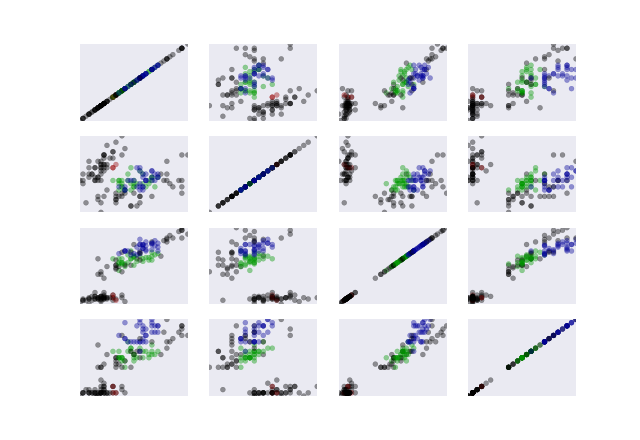

In [315]:
color_map = {
    'setosa': (0.6, 0, 0, 0.4),
    'versicolor': (0, 0.6, 0, 0.4),
    'virginica': (0, 0, 0.6, 0.4)
}
colors = np.array([color_map[x] for x in flowers.index])  
DrawClass(data = flowers, colors = colors)

I discussed HW with Kevin Li, Ying Cao, Tugce, Jing Dai